In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
#import statements
import sys
import random
import warnings
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from itertools import chain

from skimage.transform import resize
from skimage.morphology import label
from skimage.io import imread, imshow, imread_collection, concatenate_images

from keras import backend as K
from keras.layers import Input
from keras.preprocessing import image
from keras.layers.merge import concatenate
from keras.models import Model, load_model
from keras.layers.core import Dropout, Lambda
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.convolutional import Conv2D, Conv2DTranspose

seed1 = 42
np.random.seed(10)
tf.set_random_seed(4422)

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

/N/u/gautham4/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.33
sess = tf.InteractiveSession(config = config)

In [4]:
train_path = '/N/u/gautham4/Final_Project/data/data/stage1_train/'
test_path = '/N/u/gautham4/Final_Project/data/data/stage1_test/'

###  1. Data Preprocessing

In [5]:
#Getting the ids
train_ids = next(os.walk(train_path))[1]
test_ids = next(os.walk(test_path))[1]

In [6]:
#Loading the Parameters
batch_size = 10
image_width = 128
image_height = 128
channels = 3

In [7]:
#Resizing the images
X_train = np.zeros((len(train_ids), image_height, image_width, channels), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), image_height, image_width, 1), dtype=np.bool)
for i, id_ in enumerate(train_ids):
    img = imread(train_path + id_ + '/images/' + id_ + '.png')[:,:,:channels]
    X_train[i] = resize(img, (image_height, image_width), mode='constant', preserve_range=True)
    combined_mask = np.zeros((image_height, image_width, 1), dtype=np.bool)
    for file in next(os.walk(train_path + id_ + '/masks/'))[2]:
        mask = imread(train_path + id_  + '/masks/' + file)
        mask = np.expand_dims(resize(mask, (image_height, image_width), mode='constant', 
                                      preserve_range=True), axis=-1)
        combined_mask = np.maximum(combined_mask, mask)
    Y_train[i] = combined_mask
print('Resized the train images and masks.')

Resized the train images and masks.


In [8]:
X_test = np.zeros((len(test_ids), image_height, image_width, channels), dtype=np.uint8)
sizes_test = []
for i, id_ in enumerate(test_ids):
    img = imread(test_path + id_ + '/images/' + id_ + '.png')[:,:,:channels]
    sizes_test.append([img.shape[0], img.shape[1]])
    X_test[i] = resize(img, (image_height, image_width), mode='constant', preserve_range=True)

print('Resized the test images')

Resized the test images


In [42]:
import numpy as np 

def RLE_encoding_to_mask(rle_line,height,width):
  rows,cols = height,width
  rleNumbers = [int(numstring) for numstring in rle_line.split(' ')]
  rle_p = np.array(rleNumbers).reshape(-1,2)
  img = np.zeros(rows*cols,dtype=np.uint8)
  for index,length in rle_p:
    index -= 1
    img[index:index+length] = 255
  img = img.reshape(cols,rows)
  img = img.T
  return img

In [43]:
test_df = pd.read_csv('/N/u/gautham4/Final_Project/data/data/stage1_solution.csv')

print('Creating Test masks...')

Y_test = np.zeros((len(train_ids), image_height, image_width, 1), dtype=np.bool)
for n, id_ in enumerate(test_ids):
   mask = np.zeros((image_height, image_width, 1), dtype=np.bool)
   df = test_df.loc[test_df['ImageId'] == id_]
   
   for i in range (0,(df).shape[0]) :
         mask_ = RLE_encoding_to_mask(df.iloc[i,1],256,256)
         mask_ = np.expand_dims(resize(mask_, (image_height, image_width), mode='constant', 
                                      preserve_range=True), axis=-1)
         mask = np.maximum(mask, mask_)
   Y_test[n] = mask


print('Done')



Creating Test masks...
Done


###  2. Data Augmentation

In [9]:
# Images and Mask generators
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=56)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=56)

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=56)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=56)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=batch_size,shuffle=True, seed=56)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=batch_size,shuffle=True, seed=56)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=batch_size,shuffle=True, seed=56)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=batch_size,shuffle=True, seed=56)

train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [10]:
def iou_metric(true, pred, print_table=False):
    true = label(true > 0.5)
    pred = label(pred > 0.5)
    i = np.histogram2d(true.flatten(), pred.flatten(), bins=(len(np.unique(true)), len(np.unique(pred))))[0]#intersection of true and prediction
    ta = np.histogram(true, bins = len(np.unique(true)))[0] #Area of true label
    pa = np.histogram(pred, bins = len(np.unique(pred)))[0] #Area of predicted label
    u = np.expand_dims(ta, -1) + np.expand_dims(pa, 0) - i  # true+pred-intersection
    i = i[1:,1:]
    u = u[1:,1:]
    u[u == 0] = 1e-9
    precisions = []   
    for threshold in np.arange(0.5, 1.0, 0.05):
        tp = np.sum(np.sum(((i/u) > threshold), axis=1) == 1) #true positive
        fp = np.sum(np.sum(((i/u) > threshold), axis=0) == 0) #false positive
        fn = np.sum(np.sum(((i/u) > threshold), axis=1) == 0) #false negative
        precisions.append(tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0)            
    return np.mean(precisions)

def iou_metric_batch(true, pred):
    metric = [iou_metric(true[i], pred[i]) for i in range(true.shape[0])]
    return np.array(np.mean(metric), dtype=np.float32)

def mean_iou(true, pred):
    return tf.py_func(iou_metric_batch, [true, pred], tf.float32)

###  3. U-net

In [11]:
#Building the model
inputs = Input((image_height, image_width, channels))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

model_DA = Model(inputs=[inputs], outputs=[outputs])
model_DA.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model_DA.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [12]:
# Fitting model without augmented Data
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('U-Net-model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/100
603/603 [==============================] - 7s 11ms/step - loss: 0.2762 - mean_iou: 0.1369 - val_loss: 0.1292 - val_mean_iou: 0.2699

Epoch 00001: val_loss improved from inf to 0.12915, saving model to U-Net-model-dsbowl2018-1.h5
Epoch 2/100
603/603 [==============================] - 4s 7ms/step - loss: 0.1557 - mean_iou: 0.2632 - val_loss: 0.1270 - val_mean_iou: 0.3491

Epoch 00002: val_loss improved from 0.12915 to 0.12702, saving model to U-Net-model-dsbowl2018-1.h5
Epoch 3/100
603/603 [==============================] - 4s 7ms/step - loss: 0.1299 - mean_iou: 0.3395 - val_loss: 0.1278 - val_mean_iou: 0.3672

Epoch 00003: val_loss did not improve
Epoch 4/100
603/603 [==============================] - 4s 7ms/step - loss: 0.1148 - mean_iou: 0.3819 - val_loss: 0.1128 - val_mean_iou: 0.4147

Epoch 00004: val_loss improved from 0.12702 to 0.11281, saving model to U-Net-model-dsbowl2018-1.h5
Epoch 5/100
603/603 [=======================

In [13]:
# Fitting the model with Augmented Data
earlystopper_DA = EarlyStopping(patience=5, verbose=1)
checkpointer_DA = ModelCheckpoint('U-Net-with-data-augmentation-model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results_DA = model_DA.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=50, callbacks=[earlystopper_DA, checkpointer_DA])

Epoch 1/50
250/250 [==============================] - 18s 70ms/step - loss: 0.0984 - mean_iou: 0.4503 - val_loss: 0.0710 - val_mean_iou: 0.5418

Epoch 00001: val_loss improved from inf to 0.07101, saving model to U-Net-with-data-augmentation-model-dsbowl2018-1.h5
Epoch 2/50
250/250 [==============================] - 16s 64ms/step - loss: 0.1003 - mean_iou: 0.4532 - val_loss: 0.0702 - val_mean_iou: 0.5474

Epoch 00002: val_loss improved from 0.07101 to 0.07017, saving model to U-Net-with-data-augmentation-model-dsbowl2018-1.h5
Epoch 3/50
250/250 [==============================] - 15s 62ms/step - loss: 0.1032 - mean_iou: 0.4468 - val_loss: 0.0671 - val_mean_iou: 0.5194

Epoch 00003: val_loss improved from 0.07017 to 0.06707, saving model to U-Net-with-data-augmentation-model-dsbowl2018-1.h5
Epoch 4/50
250/250 [==============================] - 15s 60ms/step - loss: 0.1043 - mean_iou: 0.4431 - val_loss: 0.0733 - val_mean_iou: 0.5515

Epoch 00004: val_loss did not improve
Epoch 5/50
250/25

In [31]:
# Predicting on train, val and test using model built on data augmentation
best_model = load_model('U-Net-model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = best_model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = best_model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = best_model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 0s 566us/step


/N/u/gautham4/.local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


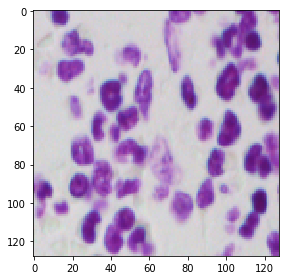

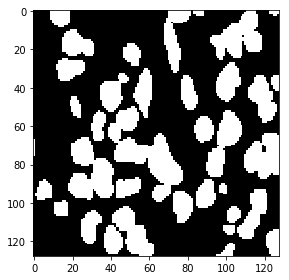

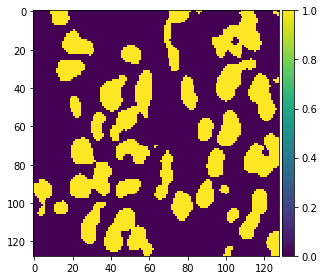

In [32]:
# Checking the predictions on training samples.
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

/N/u/gautham4/.local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


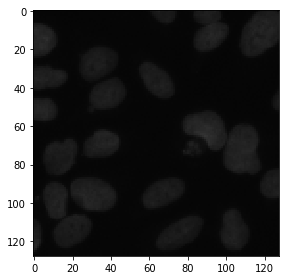

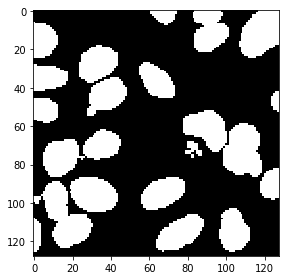

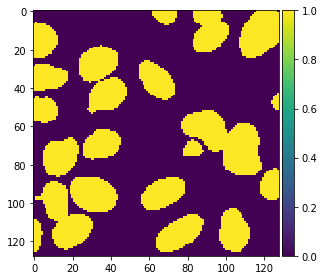

In [33]:
# Checking the predictions on validation samples.
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()



In [46]:
no_aug_model = 'U-Net-model-dsbowl2018-1.h5'
aug_model = 'U-Net-with-data-augmentation-model-dsbowl2018-1.h5'

In [71]:
def display_predicted_images(model_name):    

    # Predicting on train, val and test using models that we built 
    best_model = load_model(model_name, custom_objects={'mean_iou': mean_iou})
    preds_train = best_model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
    preds_val = best_model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
    preds_test = best_model.predict(X_test, verbose=1)

    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)

    # Create list of upsampled test masks
    preds_test_upsampled = []
    for i in range(len(preds_test)):
        preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),(sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))
    
    
    # Checking the predictions on training samples.
    ix = random.randint(0, len(preds_train_t))
    imshow(X_train[ix])
    plt.show()
    imshow(np.squeeze(Y_train[ix]))
    plt.show()
    imshow(np.squeeze(preds_train_t[ix]))
    plt.show()


    # Checking the predictions on validation samples.
    ix = random.randint(0, len(preds_val_t))
    imshow(X_train[int(X_train.shape[0]*0.9):][ix])
    plt.show()
    imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
    plt.show()
    imshow(np.squeeze(preds_val_t[ix]))
    plt.show()
    

def display_results(model_name) :
    # Predicting on train, val and test using models that we built 
    best_model = load_model(model_name, custom_objects={'mean_iou': mean_iou})
    preds_train = best_model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
    preds_val = best_model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
    preds_test = best_model.predict(X_test, verbose=1)

    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)

    # Create list of upsampled test masks
    preds_test_upsampled = []
    for i in range(len(preds_test)):
        preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),(sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))
    
    
    
    print('Results for'+model_name+'\n\n')
    iou = []
    for i in range(0,603):
        iou.append(iou_metric(np.squeeze(Y_train[i]), np.squeeze(preds_train_t[i])))
    iou = np.asarray(iou)
    print('Train Mean Precision Score')
    print(iou.mean(),"\n")
    
    
    
    iou_val = []
    for i in range(0,67):
        iou_val.append(iou_metric(np.squeeze(Y_train[i+603]), np.squeeze(preds_val_t[i])))
    iou_val = np.asarray(iou_val)
    print('Validation Mean Precision Score')
    print(iou_val.mean(), "\n")
    
    
    
    iou_t = []
    for i in range(0,65):
        iou_t.append(iou_metric(np.squeeze(Y_test[i]), np.squeeze(preds_test_t[i])))
    iou_t = np.asarray(iou_t)
    print('Test Mean Precision Score')
    print(iou_t.mean(), "\n")
    

65/65 [==============================] - 0s 509us/step


/N/u/gautham4/.local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


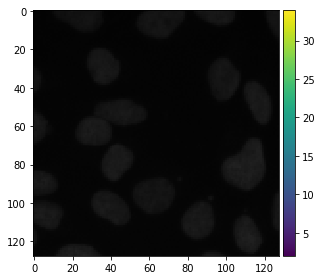

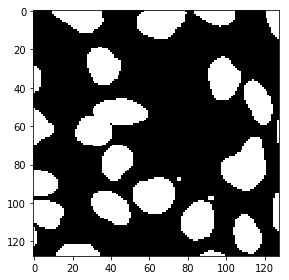

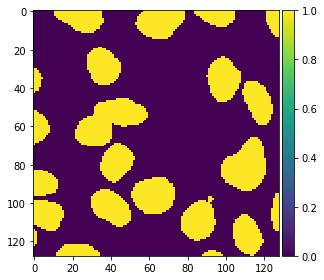

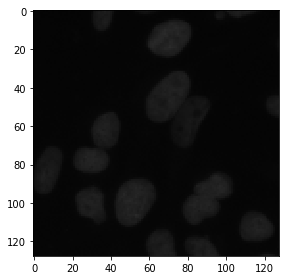

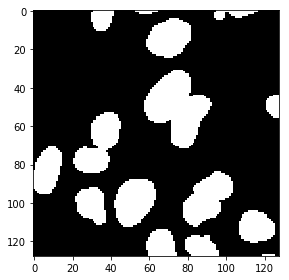

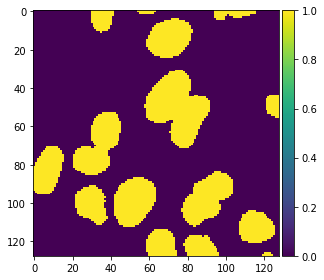

In [72]:
display_predicted_images(aug_model)

In [73]:
display_results(no_aug_model)

65/65 [==============================] - 0s 491us/step
Results forU-Net-model-dsbowl2018-1.h5


Train Mean Precision Score
0.5451173983819105 

Validation Mean Precision Score
0.5463090772513925 

Test Mean Precision Score
0.20944041762083684 



In [74]:
display_results(aug_model)

65/65 [==============================] - 0s 503us/step
Results forU-Net-with-data-augmentation-model-dsbowl2018-1.h5


Train Mean Precision Score
0.5547620326087722 

Validation Mean Precision Score
0.5421579005584484 

Test Mean Precision Score
0.20418779831881606 

